## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
from numpy import *
from time import sleep
import os
import errno
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import pickle
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import glorot_normal
from keras.utils import np_utils
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

Using TensorFlow backend.
C:\Users\singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Data Extraction

In [2]:
#my_tar = tarfile.open('cifar-10-python.tar.gz')
#my_tar.extractall('./image_classification') # specify which folder to extract to
#my_tar.close()

In [3]:
def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError as e:  # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT:  # errno.ENOENT = no such file or directory
            raise  # re-raise exception if a different error occurred



def unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d


def read_data(folder):
    x_data_temp = []
    y_data_temp = []
    x_test_data_temp = []
    y_test_data_temp = []
    # We don't use numpy's vstack here as that would be wasteful, because every time you do a vstack, numpy would end
    # up copying the whole array to a new location. Hence we use a little trick to first store the data in a list and
    # then convert it to an numpy array

    for file in os.listdir(folder):
        if file.endswith(".meta") or file.endswith(".html"):
            print("Ignoring html and meta files")
        elif "test_batch" in file:
            # test data file detected. we are gonna load it separately
            test_data_temp = unpickle(folder + "/" + file)
            x_test_data_temp.append(test_data_temp[b'data'])
            y_test_data_temp.append(test_data_temp[b'labels'])
        else:
            temp_data = unpickle(folder + "/" + file)
            x_data_temp.append(temp_data[b'data'])
            y_data_temp.append(temp_data[b'labels'])
    x_data = array(x_data_temp)
    y_data = array(y_data_temp)
    x_test_data = array(x_test_data_temp)
    y_test_data = array(y_test_data_temp)
    return [x_data, y_data, x_test_data, y_test_data]

## Data Processing

In [4]:
X_train_temp, y_train_temp, X_test_temp, y_test_temp = read_data("./cifar-10-batches-py")

Ignoring html and meta files
Ignoring html and meta files


In [5]:
print('Current shape of training data is: ', X_train_temp.shape)
print('Current shape of training labels is: ', y_train_temp.shape)

Current shape of training data is:  (5, 10000, 3072)
Current shape of training labels is:  (5, 10000)


In [6]:
X_train_temp = X_train_temp.reshape(X_train_temp.shape[0] * X_train_temp.shape[1], X_train_temp.shape[2])
y_train_temp = y_train_temp.reshape(y_train_temp.shape[0] * y_train_temp.shape[1])
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Similarly for X_test_temp and y_test_data

X_test = X_test_temp.reshape(X_test_temp.shape[0] * X_test_temp.shape[1], X_test_temp.shape[2])
y_test = y_test_temp.reshape(y_test_temp.shape[0] * y_test_temp.shape[1])

print('Transformed shape of training data is: ',X_train_temp.shape)
print('Transformed shape of training labels is: ', y_train_temp.shape)

print('Transformed shape of training data is: ', X_test.shape)
print('Transformed shape of test labels is: ', y_test.shape)


Transformed shape of training data is:  (50000, 3072)
Transformed shape of training labels is:  (50000,)
Transformed shape of training data is:  (10000, 3072)
Transformed shape of test labels is:  (10000,)


In [7]:
# Splitting X and y in training and val data
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=0, stratify=y_train_temp, shuffle=True)

# Model Building/Evaluation

## 1. Convolutional Neural Networks

In [8]:
# Keras Parameters
BATCH_NORM = True
batch_size = 32
nb_classes = 10
nb_epoch = 20
img_rows, img_col = 32, 32
img_channels = 3
nb_filters = 32
nb_pool = 2
nb_conv = 3

# Now that our data has been shuffled and spitted,  lets reshape it and get it ready to be fed into our CCN model

X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1)
y_train = np_utils.to_categorical(y_train, nb_classes)

X_val = X_val.reshape((len(X_val), 3, 32, 32)).transpose(0, 2, 3, 1)
y_val = np_utils.to_categorical(y_val, nb_classes)

X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1)
y_test = np_utils.to_categorical(y_test, nb_classes)

# Finally print shape of this data :

print('Shape of training data is: ',X_train.shape)
print('Shape of training labels is: ', y_train.shape)

print('\nShape of validation data is: ', X_test.shape)
print('Shape of validation labels is: ', y_test.shape)

print('\nShape of test data is: ', X_test.shape)
print('Shape of test labels is: ', y_test.shape)


# Regularize the data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

Shape of training data is:  (40000, 32, 32, 3)
Shape of training labels is:  (40000, 10)

Shape of validation data is:  (10000, 32, 32, 3)
Shape of validation labels is:  (10000, 10)

Shape of test data is:  (10000, 32, 32, 3)
Shape of test labels is:  (10000, 10)


In [9]:
#def _get_available_gpus():  

#    if tfback._LOCAL_DEVICES is None:  
#        devices = tf.config.list_logical_devices()  
#        tfback._LOCAL_DEVICES = [x.name for x in devices]  
#    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


#tfback._get_available_gpus = _get_available_gpus

In [10]:
# Starting with Keras now

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid',
                 activation='relu',
                 input_shape=(img_rows, img_col, img_channels)))

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.2))

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 32)         

In [27]:
#history = model.fit(X_train, y_train, batch_size=batch_size, epochs = nb_epoch, 
#                    verbose = 1, validation_data = (X_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 89s 2ms/step - loss: 1.5970 - accuracy: 0.4156 - val_loss: 1.3521 - val_accuracy: 0.5291
Epoch 2/20
40000/40000 [==============================] - 90s 2ms/step - loss: 1.2492 - accuracy: 0.5525 - val_loss: 1.1151 - val_accuracy: 0.6023
Epoch 3/20
40000/40000 [==============================] - 91s 2ms/step - loss: 1.1018 - accuracy: 0.6080 - val_loss: 1.0037 - val_accuracy: 0.6526
Epoch 4/20
40000/40000 [==============================] - 90s 2ms/step - loss: 1.0121 - accuracy: 0.6431 - val_loss: 0.9298 - val_accuracy: 0.6802
Epoch 5/20
40000/40000 [==============================] - 90s 2ms/step - loss: 0.9413 - accuracy: 0.6698 - val_loss: 0.8913 - val_accuracy: 0.6925
Epoch 6/20
40000/40000 [==============================] - 90s 2ms/step - loss: 0.8920 - accuracy: 0.6866 - val_loss: 0.8672 - val_accuracy: 0.7017
Epoch 7/20
40000/40000 [==============================] - 88s 2ms/st

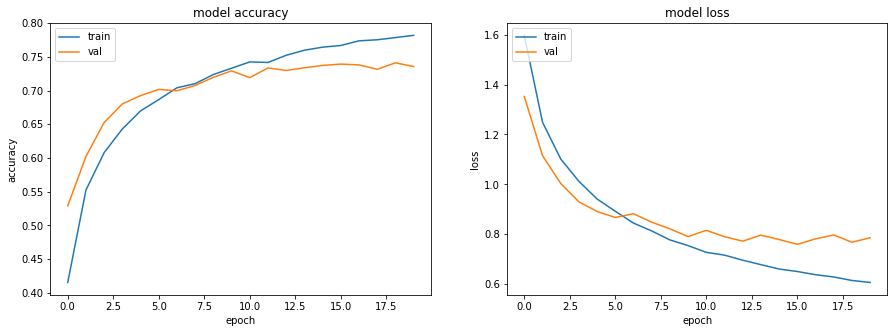

In [29]:
f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# summarize history for accuracy
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
#model_1.save('model.h5')  # creates a HDF5 file 'model.h5'
#del model

model.load_weights("model.h5")

## 2. VGG-16

In [12]:
# Define Model
def vgg_base_model():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(img_rows, img_col, img_channels), name='block1_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(128, (3, 3), padding='same', name='block2_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(256, (3, 3), padding='same', name='block3_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block4_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv1'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv3'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Conv2D(512, (3, 3), padding='same', name='block5_conv4'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))

    model.add(Flatten())

    model.add(Dense(4096))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, name='fc2'))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(BatchNormalization()) if BATCH_NORM else None
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.0005, decay=0, nesterov=True)

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

cnn_n = vgg_base_model()
cnn_n.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)       

In [67]:
#cnn = cnn_n.fit(X_train, y_train, batch_size=256, epochs = 10, 
#                verbose = 1, validation_data = (X_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 2642s 66ms/step - loss: 2.5237 - accuracy: 0.1347 - val_loss: 2.4485 - val_accuracy: 0.1000
Epoch 2/10
40000/40000 [==============================] - 2631s 66ms/step - loss: 2.2406 - accuracy: 0.1963 - val_loss: 2.5860 - val_accuracy: 0.1000
Epoch 3/10
40000/40000 [==============================] - 2471s 62ms/step - loss: 2.0554 - accuracy: 0.2416 - val_loss: 2.3138 - val_accuracy: 0.1528
Epoch 4/10
40000/40000 [==============================] - 2733s 68ms/step - loss: 1.9352 - accuracy: 0.2836 - val_loss: 1.9122 - val_accuracy: 0.2683
Epoch 5/10
40000/40000 [==============================] - 3001s 75ms/step - loss: 1.8611 - accuracy: 0.3133 - val_loss: 1.7778 - val_accuracy: 0.3492
Epoch 6/10
40000/40000 [==============================] - 2470s 62ms/step - loss: 1.7967 - accuracy: 0.3438 - val_loss: 1.7263 - val_accuracy: 0.3802
Epoch 7/10
40000/40000 [==========================

In [24]:
#cnn_n.save('cnn_n.h5')
#del cnn_n

cnn_n.load_weights("cnn_n.h5")

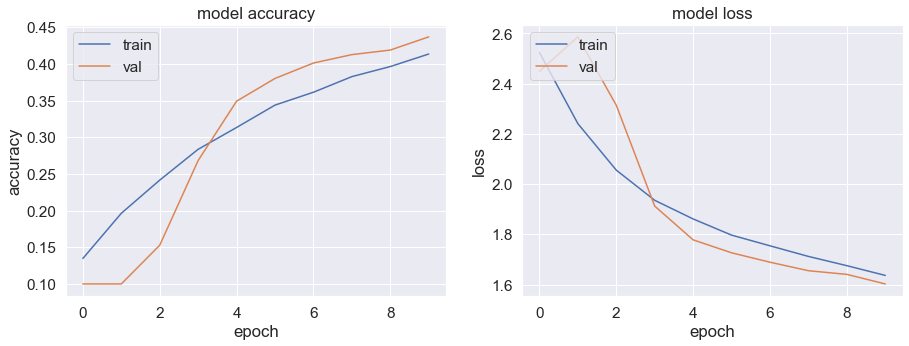

In [94]:
f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# summarize history for accuracy
ax.plot(cnn.history['accuracy'])
ax.plot(cnn.history['val_accuracy'])
ax.set_title('model accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(cnn.history['loss'])
ax2.plot(cnn.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

## Out of Sample Performance

In [25]:
# Test this trained model on our test data
score = model.evaluate(X_test, y_test, verbose=0)
print("Mean loss on test data is :", score[0])
print("\nMean accuracy on test data is :", score[1])
#print(model.predict_classes(X_test[1:50]))
#print(y_test[1:50])

Mean loss on test data is : 0.7676809642791748

Mean accuracy on test data is :  0.7409999966621399


## Confusion Matrix

NameError: name 'ax' is not defined

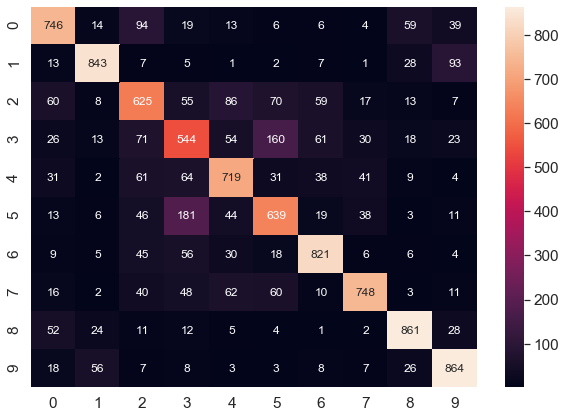

In [14]:
Y_pred = model.predict(X_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

#for ix in range(10):
#    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
#print(cm)

# Visualizing of confusion matrix
df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size
plt.show()

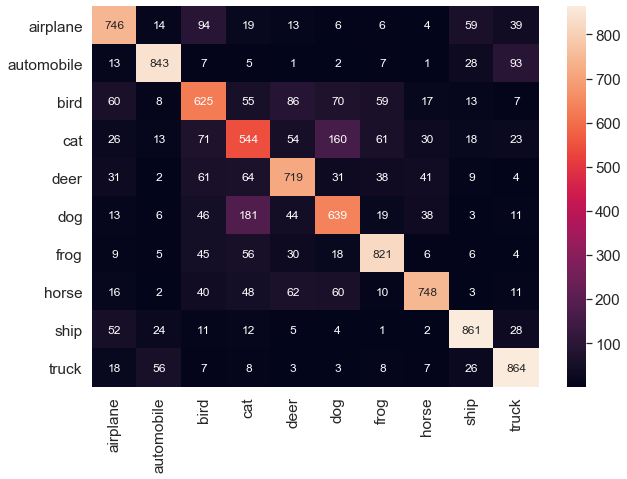

In [17]:
# Visualizing of confusion matrix
df_cm = pd.DataFrame(cm, labels,labels)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size
plt.show()

## Image label Prediction

In [132]:
def image_prediction(img):
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img) 
    plt.show()
    
    predict = model.predict_classes(img.reshape(1, 3, 32, 32).transpose(0, 2, 3, 1))
    
    return print("Predicted label for the image is", labels[predict[0]])

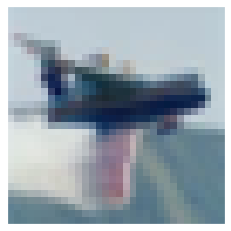

Predicted label for the image is airplane


In [153]:
image_prediction(X_test[random.randint(0, 10000)])